In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
allocs = pd.Series([.05, .3, .35, .3, 1], index=['CL', 'ES', 'GC', 'NQ', 'total'])
cash = 100000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-03-04_20-48_20190101_20190103.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df

,contract,action,amount,price,order_id,reason,commission,realizedPNL,comm_reports,cash
time,,,,,,,,,,
2019-01-02 01:56:00,NQ,BUY,3,6382.75,1,ENTRY,6.30,0.00,"[CommissionReport(execId=1, commission=6.30000...",100000.00
2019-01-02 02:10:00,ES,BUY,3,2518.75,3,ENTRY,6.30,0.00,"[CommissionReport(execId=2, commission=6.30000...",100000.00
2019-01-02 02:55:00,NQ,SELL,3,6354.75,2,STOP-LOSS,6.30,-1692.60,"[CommissionReport(execId=3, commission=6.30000...",98307.40
2019-01-02 03:37:00,ES,SELL,3,2488.50,4,STOP-LOSS,6.30,-4550.10,"[CommissionReport(execId=4, commission=6.30000...",93757.30
2019-01-02 06:19:00,GC,BUY,4,1287.10,5,ENTRY,9.68,0.00,"[CommissionReport(execId=5, commission=9.68, c...",93757.30
2019-01-02 08:27:00,GC,SELL,4,1287.10,6,STOP-LOSS,9.68,-19.36,"[CommissionReport(execId=6, commission=9.68, c...",93737.94
2019-01-02 09:15:00,CL,SELL,1,44.69,7,ENTRY,2.37,0.00,"[CommissionReport(execId=7, commission=2.37, c...",93737.94
2019-01-02 09:19:00,NQ,SELL,3,6219.25,9,ENTRY,6.30,0.00,"[CommissionReport(execId=8, commission=6.30000...",93737.94
2019-01-02 09:42:00,GC,BUY,4,1289.60,11,ENTRY,9.68,0.00,"[CommissionReport(execId=9, commission=9.68, c...",93737.94


In [4]:
df[(df['contract'] == 'ES') & (df['realizedPNL'] == 0)].count()

contract        1
action          1
amount          1
price           1
order_id        1
reason          1
commission      1
realizedPNL     1
comm_reports    1
cash            1
dtype: int64

In [17]:
df[df['contract'] == 'CL']

,contract,action,amount,price,order_id,reason,commission,realizedPNL,comm_reports,cash
time,,,,,,,,,,
2019-01-02 09:15:00,CL,SELL,1,44.69,7,ENTRY,2.37,0.00,"[CommissionReport(execId=7, commission=2.37, c...",93737.94
2019-01-02 10:09:00,CL,BUY,1,44.77,8,STOP-LOSS,2.37,-84.74,"[CommissionReport(execId=10, commission=2.37, ...",93653.20
2019-01-02 15:36:00,CL,SELL,1,44.55,13,ENTRY,2.37,0.00,"[CommissionReport(execId=13, commission=2.37, ...",95276.24
2019-01-02 15:56:00,CL,BUY,1,44.70,14,STOP-LOSS,2.37,-154.74,"[CommissionReport(execId=14, commission=2.37, ...",95121.50
2019-01-02 16:15:00,CL,BUY,1,46.09,15,ENTRY,2.37,0.00,"[CommissionReport(execId=15, commission=2.37, ...",95121.50
2019-01-02 16:30:00,CL,SELL,1,46.61,16,STOP-LOSS,2.37,515.26,"[CommissionReport(execId=16, commission=2.37, ...",95636.76
2019-01-02 16:49:00,CL,BUY,1,46.92,17,ENTRY,2.37,0.00,"[CommissionReport(execId=17, commission=2.37, ...",95636.76
2019-01-02 17:27:00,CL,SELL,1,47.43,18,STOP-LOSS,2.37,505.26,"[CommissionReport(execId=18, commission=2.37, ...",96142.02


In [6]:
df.groupby('contract').realizedPNL.sum()

contract
CL     781.04
ES   -4550.10
GC    -438.72
NQ     997.20
Name: realizedPNL, dtype: float64

In [7]:
df.realizedPNL.sum()

-3210.5799999999995

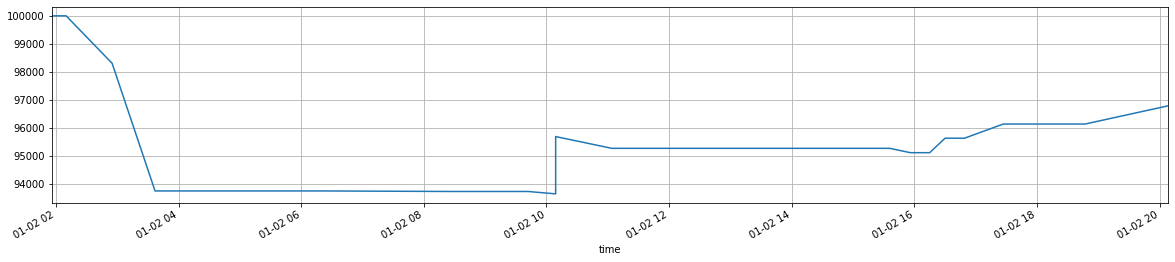

In [8]:
df.cash.plot(figsize=(20,4), grid=True);

In [9]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [10]:
# number of trades
trades = df.groupby('contract').action.count()
trades

contract
CL    8
ES    2
GC    4
NQ    6
Name: action, dtype: int64

In [11]:
# commission paid
df.groupby('contract').commission.sum()

contract
CL    18.96
ES    12.60
GC    38.72
NQ    37.80
Name: commission, dtype: float64

In [12]:
df.commission.sum()

108.08000000000001

In [13]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
NQ,0.67,332.40,1344.90,-1692.60,0.79,342.53,3.0
ES,0.00,-4550.10,NaN,-4550.10,NaN,NaN,1.0
GC,0.00,-219.36,NaN,-219.36,NaN,NaN,2.0
CL,0.50,195.26,510.26,-119.74,4.26,195.26,4.0
total,0.40,-321.06,927.58,-1153.48,0.80,-321.06,10.0


In [14]:
daily = by_contract.resample('B').sum()
daily = daily.cumsum() +  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [15]:
# instrument correlations
log_returns = np.log(daily.pct_change()[1:] + 1)
log_returns.corr()

contract,CL,ES,GC,NQ,total
contract,,,,,
CL,NaN,NaN,NaN,NaN,NaN
ES,NaN,NaN,NaN,NaN,NaN
GC,NaN,NaN,NaN,NaN,NaN
NQ,NaN,NaN,NaN,NaN,NaN
total,NaN,NaN,NaN,NaN,NaN


In [16]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

TypeError: no numeric data to plot

In [ ]:
returns = daily.pct_change()
returns.iloc[0] = (daily.iloc[0] / (allocs * cash))-1
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [ ]:
stats = pd.DataFrame()
for col in returns.columns:
    stats[col] = perf_stats(returns[col])
stats

In [ ]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

In [ ]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

In [ ]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]